# Predictive Maintenance for Turbofan Engine Dataset


## Extract, Transform and Load

In [11]:
import keras
import keras.backend as K
from keras.layers.core import Activation
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout, LSTM

print "Keras version", keras.__version__

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn import preprocessing

# Setting seed for reproducibility
np.random.seed(1234)  
PYTHONHASHSEED = 0

# define path to save model
model_path = 'regression_model.h5'

/Users/manelmaragall/anaconda/envs/TFM/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Keras version 2.1.5


## Train Data

In [12]:
# read training data - It is the aircraft engine run-to-failure data.
train_df = pd.read_csv('Dataset/PM_train.txt', sep=" ", header=None)
train_df.drop(train_df.columns[[26, 27]], axis=1, inplace=True)
train_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']

train_df = train_df.sort_values(['id','cycle'])

# Data Labeling - generate column RUL (Remaining Useful Life or Time to Failure)
rul = pd.DataFrame(train_df.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
train_df = train_df.merge(rul, on=['id'], how='left')
train_df['RUL'] = train_df['max'] - train_df['cycle']
train_df.drop('max', axis=1, inplace=True)

# MinMax normalization (from 0 to 1)
train_df['cycle_norm'] = train_df['cycle']
cols_normalize = train_df.columns.difference(['id','cycle','RUL','label1','label2'])
min_max_scaler = preprocessing.MinMaxScaler()
norm_train_df = pd.DataFrame(min_max_scaler.fit_transform(train_df[cols_normalize]), 
                             columns=cols_normalize, 
                             index=train_df.index)
join_df = train_df[train_df.columns.difference(cols_normalize)].join(norm_train_df)
train_df = join_df.reindex(columns = train_df.columns)
train_df.head()

train_df[train_df["id"] == 1].tail()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s14,s15,s16,s17,s18,s19,s20,s21,RUL,cycle_norm
187,1,188,0.114943,0.750000,0.0,0.0,0.765060,0.683235,0.684166,0.0,...,0.091599,0.753367,0.0,0.666667,0.0,0.0,0.286822,0.089202,4,0.518006
188,1,189,0.465517,0.666667,0.0,0.0,0.894578,0.547853,0.772451,0.0,...,0.090670,0.744132,0.0,0.583333,0.0,0.0,0.263566,0.301712,3,0.520776
189,1,190,0.344828,0.583333,0.0,0.0,0.731928,0.614345,0.737677,0.0,...,0.065229,0.759523,0.0,0.833333,0.0,0.0,0.271318,0.239299,2,0.523546
190,1,191,0.500000,0.166667,0.0,0.0,0.641566,0.682799,0.734639,0.0,...,0.075704,0.740669,0.0,0.500000,0.0,0.0,0.240310,0.324910,1,0.526316
191,1,192,0.551724,0.500000,0.0,0.0,0.701807,0.662089,0.758778,0.0,...,0.056714,0.717199,0.0,0.666667,0.0,0.0,0.263566,0.097625,0,0.529086


## Test Data

In [13]:
from sklearn import preprocessing

# read test data - It is the aircraft engine operating data without failure events recorded.
test_df = pd.read_csv('Dataset/PM_test.txt', sep=" ", header=None)
test_df.drop(test_df.columns[[26, 27]], axis=1, inplace=True)
test_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']

# MinMax normalization (from 0 to 1)
test_df['cycle_norm'] = test_df['cycle']
norm_test_df = pd.DataFrame(min_max_scaler.transform(test_df[cols_normalize]), 
                            columns=cols_normalize, 
                            index=test_df.index)
test_join_df = test_df[test_df.columns.difference(cols_normalize)].join(norm_test_df)
test_df = test_join_df.reindex(columns = test_df.columns)
test_df = test_df.reset_index(drop=True)

# read ground truth data - It contains the information of true remaining cycles for each engine in the testing data.
truth_df = pd.read_csv('Dataset/PM_truth.txt', sep=" ", header=None)
truth_df.drop(truth_df.columns[[1]], axis=1, inplace=True)
truth_df.head()

# generate column max for test data
rul = pd.DataFrame(test_df.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
truth_df.columns = ['more']
truth_df['id'] = truth_df.index + 1
truth_df['max'] = rul['max'] + truth_df['more']
truth_df.drop('more', axis=1, inplace=True)

# generate RUL for test data
test_df = test_df.merge(truth_df, on=['id'], how='left')
test_df['RUL'] = test_df['max'] - test_df['cycle']
test_df.drop('max', axis=1, inplace=True)

test_df[test_df["id"] == 1].tail()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s14,s15,s16,s17,s18,s19,s20,s21,cycle_norm,RUL
26,1,27,0.459770,0.583333,0.0,0.0,0.262048,0.340310,0.304862,0.0,...,0.140881,0.479030,0.0,0.333333,0.0,0.0,0.565891,0.688898,0.072022,116
27,1,28,0.626437,0.916667,0.0,0.0,0.216867,0.505995,0.321404,0.0,...,0.180359,0.469796,0.0,0.333333,0.0,0.0,0.534884,0.629660,0.074792,115
28,1,29,0.580460,0.583333,0.0,0.0,0.222892,0.351210,0.267725,0.0,...,0.171277,0.370527,0.0,0.333333,0.0,0.0,0.682171,0.646092,0.077562,114
29,1,30,0.356322,0.833333,0.0,0.0,0.475904,0.320035,0.316003,0.0,...,0.179843,0.331281,0.0,0.250000,0.0,0.0,0.736434,0.707954,0.080332,113
30,1,31,0.465517,0.833333,0.0,0.0,0.412651,0.221932,0.281229,0.0,...,0.155692,0.298192,0.0,0.416667,0.0,0.0,0.519380,0.636564,0.083102,112


### Generate Sequences

In [14]:
# pick a large window size of 50 cycles
sequence_length = 50
#
padding = False

# function to reshape features into (samples, time steps, features) 
def gen_sequence(id_df, seq_length, seq_cols):
    """ Only sequences that meet the window-length are considered, no padding is used. This means for testing
    we need to drop those which are below the window-length. An alternative would be to pad sequences so that
    we can use shorter ones """
    # for one id I put all the rows in a single matrix
    data_matrix = id_df[seq_cols].values
    # padding
    if padding:
        data_matrix = np.concatenate((np.zeros((seq_length-1, len(seq_cols))), data_matrix), axis=0)
    num_elements = data_matrix.shape[0]
    # Iterate over two lists in parallel.
    # For example id1 have 192 rows and sequence_length is equal to 50
    # so zip iterate over two following list of numbers (0,112),(50,192)
    # 0 50 -> from row 0 to row 50
    # 1 51 -> from row 1 to row 51
    # 2 52 -> from row 2 to row 52
    # ...
    # 111 191 -> from row 111 to 191
    for start, stop in zip(range(0, num_elements-seq_length+int(padding)), 
                           range(seq_length, num_elements+int(padding))):
        yield data_matrix[start:stop, :]
        
# pick the feature columns 
sensor_cols = ['s' + str(i) for i in range(1,22)]
sequence_cols = ['setting1', 'setting2', 'setting3', 'cycle_norm']
sequence_cols.extend(sensor_cols)

# TODO for debug 
# val is a list of 192 - 50 = 142 bi-dimensional array (50 rows x 25 columns)
val=list(gen_sequence(train_df[train_df['id']==1], sequence_length, sequence_cols))
print(len(val))

# list for the sequences
# transform each id of the train dataset in a sequence
seq_gen = [list(gen_sequence(train_df[train_df['id']==id], sequence_length, sequence_cols)) 
           for id in train_df['id'].unique()]

# generate sequences and convert to numpy array
train_X = np.concatenate(seq_gen).astype(np.float32)

# function to generate labels
def gen_labels(id_df, seq_length, label):
    """ Only sequences that meet the window-length are considered, no padding is used. This means for testing
    we need to drop those which are below the window-length. An alternative would be to pad sequences so that
    we can use shorter ones """
    # For one id I put all the labels in a single matrix.
    # For example:
    # [[1]
    # [4]
    # [1]
    # [5]
    # [9]
    # ...
    # [200]] 
    data_matrix = id_df[label].values
    num_elements = data_matrix.shape[0]
    # I have to remove the first seq_length labels
    # because for one id the first sequence of seq_length size have as target
    # the last label (the previus ones are discarded).
    # All the next id's sequences will have associated step by step one label as target.
    return data_matrix[:num_elements, :] if padding else data_matrix[seq_length:num_elements, :]

# generate labels
label_gen = [gen_labels(train_df[train_df['id']==id], sequence_length, ['RUL']) 
             for id in train_df['id'].unique()]

train_Y = np.concatenate(label_gen).astype(np.float32)

142


## Test

In [15]:
# We pick the last sequence for each id in the test data
test_X = [test_df[test_df['id']==id][sequence_cols].values[-sequence_length:] 
                       for id in test_df['id'].unique() if len(test_df[test_df['id']==id]) >= sequence_length]

test_X = np.asarray(test_X).astype(np.float32)
# Similarly, we pick the labels
y_mask = [len(test_df[test_df['id']==id]) >= sequence_length for id in test_df['id'].unique()]
test_Y = test_df.groupby('id')['RUL'].nth(-1)[y_mask].values
test_Y = test_Y.reshape(test_Y.shape[0],1).astype(np.float32)

## Recurrent Neural Networks

In [19]:
def r2_keras(y_true, y_pred):
    """Coefficient of Determination 
    """
    SS_res =  K.sum(K.square( y_true - y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

keras.metrics.r2_keras = r2_keras

In [ ]:
# Next, we build a deep network. 
# The first layer is an LSTM layer with 100 units followed by another LSTM layer with 50 units. 
# Dropout is also applied after each LSTM layer to control overfitting. 
# Final layer is a Dense output layer with single unit and linear activation since this is a regression problem.
nb_features = train_X.shape[2]
nb_out = train_Y.shape[1]

model = Sequential()

# Mask parts of the lookback period that are all zeros (i.e., unobserved) so they don't skew the model
# model.add(Masking(mask_value=0., input_shape=(sequence_length, nb_features)))

model.add(LSTM(
         input_shape=(sequence_length, nb_features),
         units=100,
         return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(
          units=50,
          return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=nb_out))
model.add(Activation("linear"))
model.compile(loss='mean_squared_error', optimizer='rmsprop',metrics=['mae',r2_keras])

print(model.summary())

# fit the network
history = model.fit(train_X, train_Y, epochs=100, batch_size=200, validation_split=0.05, verbose=2,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'),
                       keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', save_best_only=True, mode='min', verbose=0)]
          )

# list all data in history
print(history.history.keys())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 50, 100)           50400     
_________________________________________________________________
dropout_5 (Dropout)          (None, 50, 100)           0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 50)                30200     
_________________________________________________________________
dropout_6 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 51        
_________________________________________________________________
activation_7 (Activation)    (None, 1)                 0         
Total params: 80,651
Trainable params: 80,651
Non-trainable params: 0
_________________________________________________________________
None
T

In [26]:
!ls Models

regression_model.h5 rnn_1_59.h5         rnn_1_82.h5         wtte_1_234.h5


In [22]:
from keras.models import load_model
model = load_model("Models/rnn_1_82.h5")

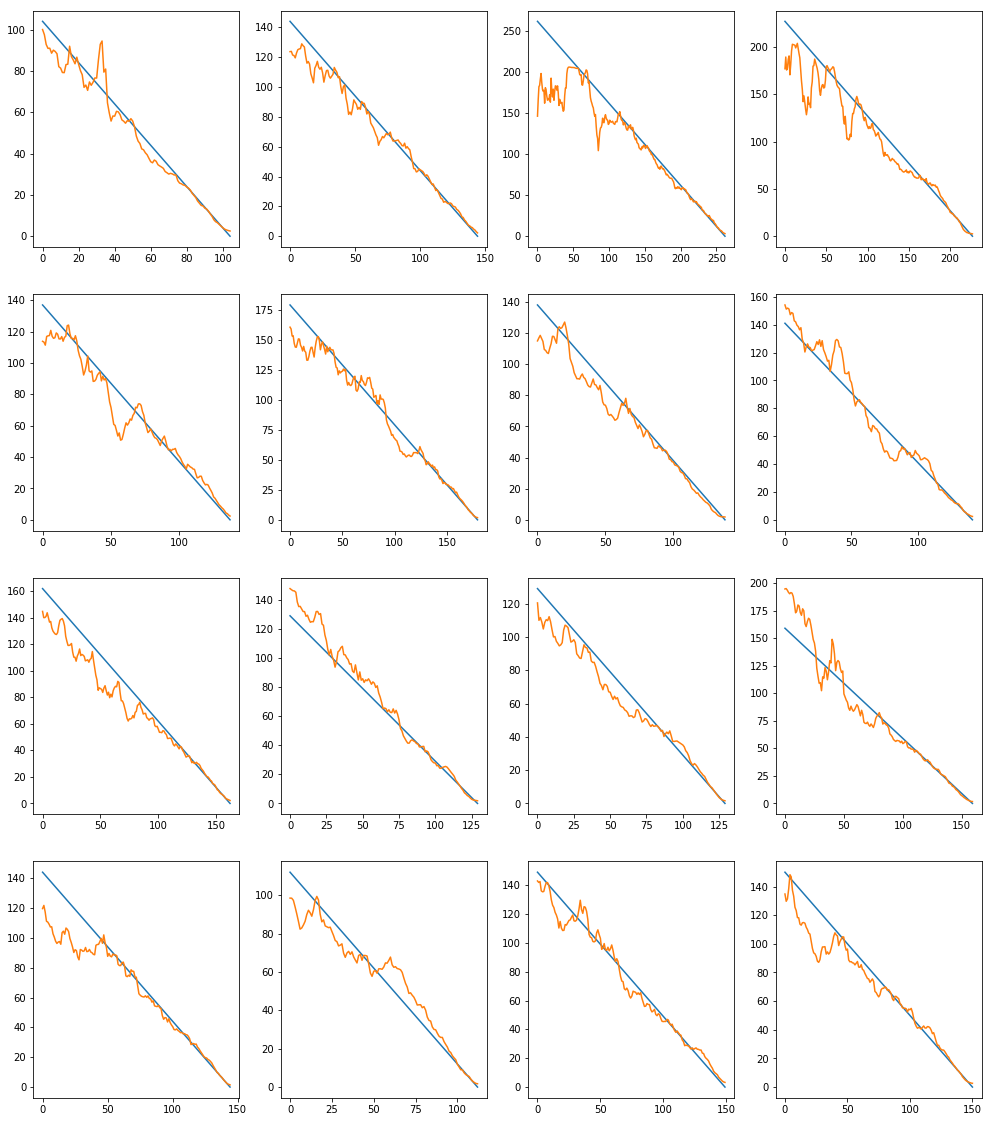

In [23]:
%matplotlib inline
import random

fig = plt.figure()
sample_size=16
lot_sample = random.sample(list(enumerate(label_gen)), sample_size)

n_cols=4
i = 1
for id,lot in lot_sample:
    ax = fig.add_subplot(sample_size/n_cols,n_cols,i)
    plt.plot(lot)
    plt.plot(model.predict(np.array(seq_gen[id])))
    i += 1
        
plt.gcf().set_size_inches((17,5*sample_size/n_cols))
# plt.grid(True)
plt.show()


MAE: 13.5587640065

R^2: 0.706963476314

Train

RMSE: 17.9430905446

R^2: 0.901398728499


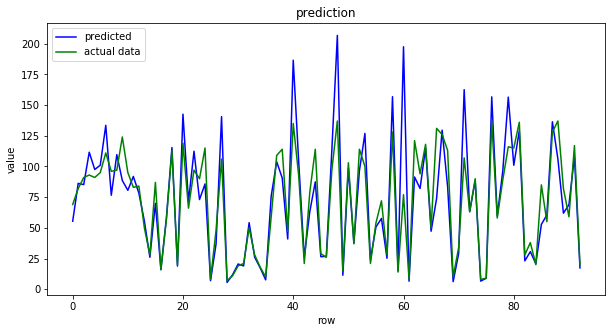

In [52]:

# test metrics
scores_test = model.evaluate(test_X, test_Y, verbose=2)
print('\nMAE: {}'.format(scores_test[1]))
print('\nR^2: {}'.format(scores_test[2]))

y_pred_train = model.predict(train_X)
y_true_train = train_Y

print "\nTrain"
print('\nRMSE: {}'.format(math.sqrt(mean_squared_error(y_true_train, y_pred_train))))
print('\nR^2: {}'.format(r2_score(y_true_train, y_pred_train)))

y_pred_test = model.predict(test_X)
y_true_test = test_Y

test_set = pd.DataFrame(y_pred_test)
test_set.to_csv('submit_test.csv', index = None)

# Plot in blue color the predicted data and in green color the
# actual data to verify visually the accuracy of the model.
fig_verify = plt.figure(figsize=(10, 5))
plt.plot(y_pred_test, color="blue")
plt.plot(y_true_test, color="green")
plt.title('prediction')
plt.ylabel('value')
plt.xlabel('row')
plt.legend(['predicted', 'actual data'], loc='upper left')
plt.show()
fig_verify.savefig("model_regression_verify.png")

## WTTE RNN

In [16]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Activation
from keras.layers import Masking
from keras.optimizers import RMSprop
from keras import backend as k
from sklearn.preprocessing import normalize

import tensorflow as tf

"""
    Discrete log-likelihood for Weibull hazard function on censored survival data
    y_true is a (samples, 2) tensor containing time-to-event (y), and an event indicator (u)
    ab_pred is a (samples, 2) tensor containing predicted Weibull alpha (a) and beta (b) parameters
    For math, see https://ragulpr.github.io/assets/draft_master_thesis_martinsson_egil_wtte_rnn_2016.pdf (Page 35)
"""
def weibull_loglik_discrete(y_true, ab_pred, name=None):
    y_ = y_true[:, 0]
    u_ = y_true[:, 1]
    a_ = ab_pred[:, 0]
    b_ = ab_pred[:, 1]

    hazard0 = k.pow((y_ + 1e-35) / a_, b_)
    hazard1 = k.pow((y_ + 1) / a_, b_)

    return -1 * k.mean(u_ * k.log(k.exp(hazard1 - hazard0) - 1.0) - hazard1)

"""
    Not used for this model, but included in case somebody needs it
    For math, see https://ragulpr.github.io/assets/draft_master_thesis_martinsson_egil_wtte_rnn_2016.pdf (Page 35)
"""
def weibull_loglik_continuous(y_true, ab_pred, name=None):
    y_ = y_true[:, 0]
    u_ = y_true[:, 1]
    a_ = ab_pred[:, 0]
    b_ = ab_pred[:, 1]

    ya = (y_ + 1e-35) / a_
    return -1 * k.mean(u_ * (k.log(b_) + b_ * k.log(ya)) - k.pow(ya, b_))


"""
    Custom Keras activation function, outputs alpha neuron using exponentiation and beta using softplus
"""
def activate(ab):
    a = k.exp(ab[:, 0])
    b = k.softplus(ab[:, 1])

    a = k.reshape(a, (k.shape(a)[0], 1))
    b = k.reshape(b, (k.shape(b)[0], 1))

    return k.concatenate((a, b), axis=1)

def mean_wtte_keras(y_pred):
    beta = tf.gather(tf.transpose(y_pred), 0)
    alpha = tf.gather(tf.transpose(y_pred), 1)
    return tf.multiply(beta, tf.exp(tf.lgamma(1 + 1./alpha)))

def mse_wtte_keras(y_true, y_pred):
    y_true = tf.gather(tf.transpose(y_true), 0)
    y_pred = mean_wtte_keras(y_pred)
    return tf.losses.mean_squared_error(y_true, y_pred)

def r2_wtte_keras(y_true, y_pred):
    """Coefficient of Determination for the output of the WTTE
    """
    y_true = tf.gather(tf.transpose(y_true), 0)
    y_pred = mean_wtte_keras(y_pred)
    return r2_keras(y_true, y_pred)

keras.losses.mean_wtte_keras = mean_wtte_keras
keras.losses.mse_wtte_keras = mse_wtte_keras
keras.losses.r2_wtte_keras = r2_wtte_keras

In [17]:
train_Y_wtte = np.concatenate((train_Y, np.ones(train_Y.shape)), axis=1)
test_Y_wtte = np.concatenate((test_Y, np.ones(test_Y.shape)), axis=1)

In [8]:

"""
    Here's the rest of the meat of the demo... actually fitting and training the model.
    We'll also make some test predictions so we can evaluate model performance.
"""

# Start building our model
model = Sequential()

# Mask parts of the lookback period that are all zeros (i.e., unobserved) so they don't skew the model
model.add(Masking(mask_value=0., input_shape=(sequence_length, nb_features)))

# LSTM is just a common type of RNN. You could also try anything else (e.g., GRU).
model.add(LSTM(100, input_dim=nb_features))

# We need 2 neurons to output Alpha and Beta parameters for our Weibull distribution
model.add(Dense(2))

# Apply the custom activation function mentioned above
model.add(Activation(activate))

# Use the discrete log-likelihood for Weibull survival data as our loss function
model.compile(loss=weibull_loglik_discrete, optimizer=RMSprop(lr=.001))


# Fit!
history = model.fit(train_X, train_Y_wtte, epochs=250, batch_size=100, verbose=2)

NameError: name 'nb_features' is not defined

In [42]:
nb_features = train_X.shape[2]
nb_out = train_Y.shape[1]

model = Sequential()

# Mask parts of the lookback period that are all zeros (i.e., unobserved) so they don't skew the model
from keras.layers import Masking
model.add(Masking(mask_value=0., input_shape=(sequence_length, nb_features)))

model.add(LSTM(
         input_shape=(sequence_length, nb_features),
         units=100,
         return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(
          units=50,
          return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(2))
model.add(Activation(activate))
model.compile(loss=weibull_loglik_discrete, optimizer='rmsprop',metrics=[r2_wtte_keras, mse_wtte_keras])

print(model.summary())
# validation_data=(test_X, test_Y_)
# fit the network
history = model.fit(train_X, train_Y_wtte, epochs=100, batch_size=200, validation_split=0.05, verbose=2,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'),
                       keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', save_best_only=True, mode='min', verbose=0)]
          )

# list all data in history
print(history.history.keys())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_6 (Masking)          (None, 50, 25)            0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 50, 100)           50400     
_________________________________________________________________
dropout_11 (Dropout)         (None, 50, 100)           0         
_________________________________________________________________
lstm_12 (LSTM)               (None, 50)                30200     
_________________________________________________________________
dropout_12 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 102       
_________________________________________________________________
activation_6 (Activation)    (None, 2)                 0         
Total para

KeyboardInterrupt: 

In [9]:
!ls Models

regression_model.h5 rnn_1_59.h5         wtte_1_234.h5


In [24]:
from keras.models import load_model
import keras.losses
keras.losses.weibull_loglik_discrete = weibull_loglik_discrete
model = load_model("Models/wtte_1_234.h5", custom_objects={'activate': activate})

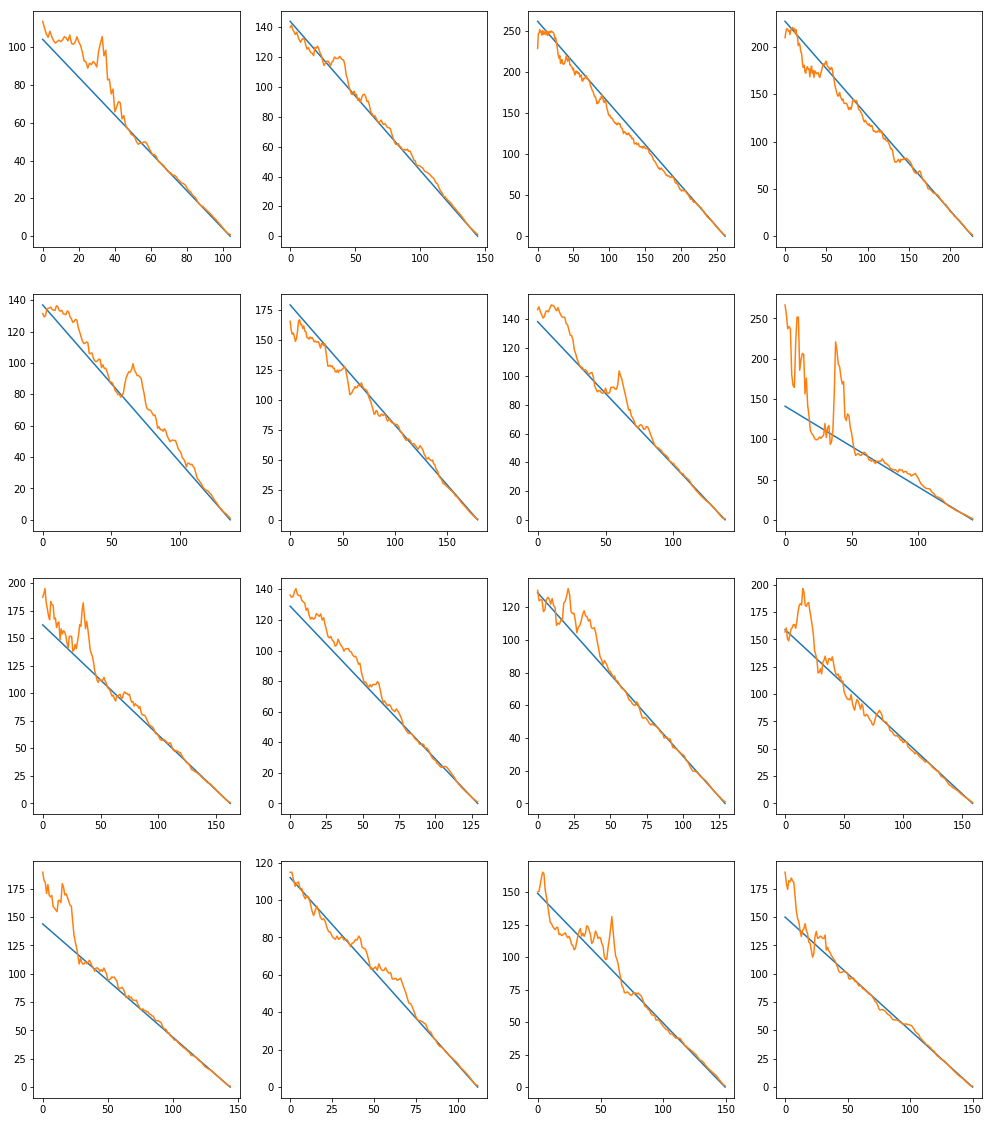

In [28]:
%matplotlib inline

fig = plt.figure()
n_cols=4
i = 1
for id,lot in lot_sample:
    ax = fig.add_subplot(sample_size/n_cols,n_cols,i)
    plt.plot(lot)
    y_pred = model.predict(np.array(seq_gen[id]))
    plt.plot([mean_weibull(alpha, beta) for beta, alpha in y_pred])
    i += 1
        
plt.gcf().set_size_inches((17,5*sample_size/n_cols))
# plt.grid(True)
plt.show()

15


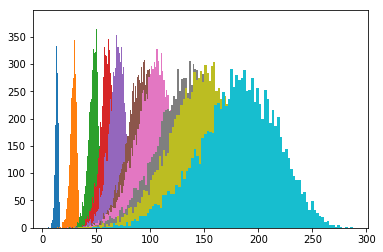

In [31]:
%matplotlib inline

fig = plt.figure()
n_cols=4
i = 1
j = 1
for id,lot in lot_sample[15:16]:
    y_pred = model.predict(np.array(seq_gen[id]))
    print len(y_pred)/10
    for beta, alpha in reversed(y_pred):
        if j%(len(y_pred)/10) == 0:
            # ax = fig.add_subplot(sample_size/n_cols,n_cols,i)
            x = inverse_cdf_weibull(np.random.uniform(0,1,10000), alpha, beta)
            plt.hist(x, bins=100)
            i += 1
        j+=1
        
# plt.gcf().set_size_inches((17,5*sample_size/n_cols))
# plt.grid(True)
plt.show()

From matplotlib 2.1 on, we can create an animation using JavaScript. This does not require any video codecs.

In [189]:
import sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

machine_id, lot = lot_sample[15]
y_pred_wtte = model.predict(np.array(seq_gen[machine_id]))
frames = zip(lot, y_pred_wtte)
freq = 2

# pad, w_pad, h_pad, and rect
fig = plt.figure()
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
fig.set_tight_layout(True)

x = np.arange(1,300.)
beta, alpha = y_pred_wtte[0]
line1, = ax1.plot(x, pdf_weibull(x, alpha, beta))
i = 0
predict_mean = mean_weibull(alpha, beta)
ax2.plot(i, lot[0], 'bo', label="True", ms=2.5)
ax2.plot(i, predict_mean, 'o', color="orange", label="Predicted", ms=2.5)
ax2.legend(loc="upper right")
# limits
ax1.set_ylim([0, 0.07])
ax2.set_ylim([0, predict_mean + 10])
ax2.set_xlim([0, len(frames)/freq + 2])
ax2.set_xticklabels([])
# acc values
acc_y_true = []
acc_y_pred = []
def update(instant):
    y_true, y_pred = instant
    beta, alpha = y_pred
    # print y_true
    line1.set_ydata(pdf_weibull(x, alpha, beta))
    global i, acc_y_true, acc_y_pred
    i += 1
    predict_mean = mean_weibull(alpha, beta)
    acc_y_pred += [predict_mean]
    acc_y_true += [y_true[0]]
    ax2.plot(range(len(acc_y_true)), acc_y_true, 'b', label="True")
    ax2.plot(range(len(acc_y_pred)), acc_y_pred, color="orange", label="Predicted")
    ax1.set_title("Predicted Weibull Distrib. (Mean: " + "{0:.1f}".format(predict_mean)
                 + ", Std: " + "{0:.1f}".format(np.sqrt(var_weibull(alpha, beta))) + ")")
    ax2.set_title("Real RUL: " + str(y_true[0]) + " cycles")
    
fig.set_size_inches(15,4)
print('\n############ Engine ' + str(machine_id) + " ############")
anim = FuncAnimation(fig, update, frames=frames[0::freq])
anim.save("Images/gif1.gif", writer="imagemagick")
plt.close()
from IPython.display import HTML
HTML('<img src="Images/gif1.gif">')


############ Engine 8 ############


In [128]:
frames[0::freq]

[(array([150]), array([204.73009 ,   5.818177], dtype=float32)),
 (array([130]), array([136.7561 ,   6.16648], dtype=float32)),
 (array([110]), array([119.45069  ,   6.5187573], dtype=float32)),
 (array([90]), array([95.41757 ,  8.052978], dtype=float32)),
 (array([70]), array([70.30289 , 10.663918], dtype=float32)),
 (array([50]), array([56.96916 , 11.968232], dtype=float32)),
 (array([30]), array([31.580976, 12.477874], dtype=float32)),
 (array([10]), array([9.869604, 9.017632], dtype=float32))]

$\mu = \beta\Gamma(1 + \alpha^{-1})$

$\sigma^2 = \beta^2[\Gamma(1 + 2\alpha^{-1}) - \Gamma^2(1 + \alpha^{-1})]$

In [27]:
from math import gamma
def mean_weibull(alpha, beta):
    return beta*gamma(1 + 1./alpha)

def var_weibull(alpha, beta):
    return beta**2*(gamma(1 + 2./alpha) - gamma(1 + 1./alpha)**2)

# l = [(mean_weibull(alpha, beta), alpha, beta) for beta, alpha in y_pred_test]
# [(r, m) for m, r in zip(l, y_true_test)]


In [55]:
model.evaluate(train_X, train_Y_wtte, verbose=2)

[3.4126150554372425, 202.72968158681655, 0.8568457137767325]

[15.644541791690294, 493.0389023647513, 0.7623613649798978]

RMSE: 25.4973937751

R^2: 0.613799998219
Train


RMSE: 15.8836024275

R^2: 0.922734430215


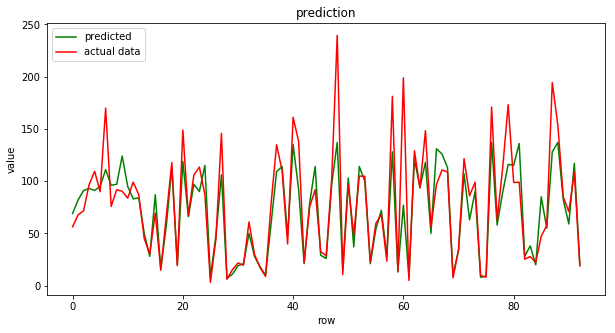

In [49]:
# test metrics
scores_test = model.evaluate(test_X, test_Y_wtte, verbose=2)
print scores_test
import math
# print('\nRMSE: {}'.format(math.sqrt(scores_test[2])))
# print('\nR^2: {}'.format(scores_test[1]))

y_pred_test = model.predict(test_X)
y_pred_test = [mean_weibull(alpha, beta) for beta, alpha in y_pred_test]
y_true_test = test_Y_wtte.T[0]

from sklearn.metrics import mean_squared_error
print('\nRMSE: {}'.format(math.sqrt(mean_squared_error(y_true_test, y_pred_test))))
print('\nR^2: {}'.format(r2_score(y_true_test, y_pred_test)))

y_pred_train = model.predict(train_X)
y_pred_train = [mean_weibull(alpha, beta) for beta, alpha in y_pred_train]
y_true_train = train_Y_wtte.T[0]

print "Train\n"
print('\nRMSE: {}'.format(math.sqrt(mean_squared_error(y_true_train, y_pred_train))))
print('\nR^2: {}'.format(r2_score(y_true_train, y_pred_train)))

test_set = pd.DataFrame(y_pred_test)
test_set.to_csv('submit_test.csv', index=None)

# Plot in blue color the predicted data and in green color the
# actual data to verify visually the accuracy of the model.
fig_verify = plt.figure(figsize=(10, 5))
plt.plot(y_true_test, color="green")
plt.plot(y_pred_test, color="red")
plt.title('prediction')
plt.ylabel('value')
plt.xlabel('row')
plt.legend(['predicted', 'actual data'], loc='upper left')
plt.show()
fig_verify.savefig("model_regression_verify.png")

In [26]:
from sklearn.metrics import r2_score
y_true = [3, -0.5, 2, 7]
y_pred = [2.5, 0.0, 2, 8]
print r2_score(y_true, y_pred)
K.eval(r2_keras(K.variable(y_true), K.variable(y_pred)))

0.9486081370449679


0.94860816

In [27]:
y_pred = model.predict(train_X)

Inverse CDF $ = \beta (-\log(1 - x))^\frac{1}{\alpha} $ when $ 0<x<1 $

6.928095 6.4536257
Mean: 6.04467134114925 6.03371582899
Variance: 1.0331271821559236 1.04767931626

9.819332 79.735016
Mean: 75.66462147550314 75.7970325855
Variance: 85.10047066444801 86.0707345473

5.46 157.85419
Mean: 145.79786597316522 145.670765166
Variance: 938.7219738681126 947.646743976


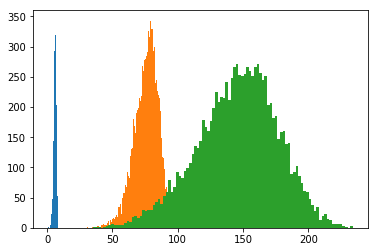

In [30]:
def inverse_cdf_weibull(x, alpha, beta):
    return beta*np.power((-np.log(1.-x)), 1./alpha)

alpha, beta = 6.4536257, 6.928095

alpha1, beta1 = 79.735016, 9.819332

alpha2, beta2 = 157.85419, 5.46

alpha, beta = beta, alpha
alpha1, beta1 = beta1, alpha1
alpha2, beta2 = beta2, alpha2

x = inverse_cdf_weibull(np.random.uniform(0,1,10000), alpha, beta)
x1 = inverse_cdf_weibull(np.random.uniform(0,1,10000), alpha1, beta1)
x2 = inverse_cdf_weibull(np.random.uniform(0,1,10000), alpha2, beta2)

print alpha, beta
print "Mean:", np.mean(x), mean_weibull(alpha, beta)
print "Variance:", np.var(x), var_weibull(alpha, beta)

print "\n", alpha1, beta1
print "Mean:", np.mean(x1), mean_weibull(alpha1, beta1)
print "Variance:", np.var(x1), var_weibull(alpha1, beta1)

print "\n", alpha2, beta2
print "Mean:", np.mean(x2), mean_weibull(alpha2, beta2)
print "Variance:", np.var(x2), var_weibull(alpha2, beta2)

plt.hist(x, bins=100)
plt.hist(x1, bins=100)
plt.hist(x2, bins=100)
plt.show()

In [183]:
10**np.log10(100)

100.0

In [193]:
import tensorflow as tf

def mean_wtte_keras(y_pred):
    beta = tf.gather(tf.transpose(y_pred), 0)
    alpha = tf.gather(tf.transpose(y_pred), 1)
    return tf.multiply(beta, tf.exp(tf.lgamma(1 + 1./alpha)))

K.eval(mean_wtte_keras(K.variable(model.predict(test_X))))

array([ 56.276646 ,  67.6662   ,  71.69847  ,  96.62592  , 109.40476  ,
        89.83319  , 169.9006   ,  75.797035 ,  91.76934  ,  90.29632  ,
        83.7522   ,  99.04816  ,  87.112305 ,  45.005672 ,  30.165201 ,
        69.40536  ,  14.719038 ,  66.60054  , 117.768036 ,  19.09594  ,
       148.8167   ,  67.25212  , 105.89647  , 113.4988   ,  86.981186 ,
         3.0345056,  44.55659  , 145.6757   ,   6.0337157,  15.312067 ,
        21.644724 ,  19.5122   ,  60.950836 ,  29.884735 ,  17.206484 ,
         8.820916 ,  78.13589  , 134.82016  , 110.103806 ,  39.952538 ,
       161.03484  , 138.08713  ,  22.126017 ,  75.357414 ,  91.86031  ,
        32.500282 ,  28.563864 , 102.4442   , 239.50926  ,  10.580019 ,
        96.36856  ,  48.572124 , 104.841255 , 104.603065 ,  22.690699 ,
        59.3872   ,  68.21561  ,  23.432127 , 181.14598  ,  12.968246 ,
       198.90607  ,   5.0016236, 129.12852  ,  93.4095   , 148.28484  ,
        56.014812 ,  96.828316 , 110.69471  , 108.69264  ,   7.4

In [34]:
def mse_wtte_keras(y_true, y_pred):
    y_true = mean_wtte_keras(y_pred)
    y_pred = tf.gather(tf.transpose(y_pred), 0)
    return tf.losses.mean_squared_error(y_true, y_pred)

In [37]:
def r2_wtte_keras(y_true, y_pred):
    """Coefficient of Determination for the output of the WTTE
    """
    y_pred = mean_weib_keras(y_pred)
    y_true = tf.gather(tf.transpose(y_true), 0)
    return r2_keras(y_true, y_pred)

In [202]:
K.eval( K.print_tensor(mse_wtte_keras(K.variable(train_Y_wtte), K.variable(model.predict(train_X))), message="Hey="))

59.43628